In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
%matplotlib inline

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [199]:
# Likelihood
def lnlike(theta, x, y,yerr,ydel):
    m ,b,n,f,o,g = theta
    model = m * x +b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f,o,g = theta
    if -2 < m < 2 and -20 < b < 20 and  -1 < n < 1 and -10 < f < 10 and -10 < o < 10 and -10 < g < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr,ydel):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr,ydel)

In [5]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[np.isfinite(df.err)]

In [6]:
#df=df[df['D (Mpc)']>35]
#df=df[df['D (Mpc)']<500]


In [7]:
df.size

1328280

In [8]:
meth=[]
ndat=[]
for i in np.unique(df.Method)[:-3]:
    df2=df[df.Method==i]
    df1=df[df.Method=='Tully-Fisher']
    meth+=[i]
    ndat+=[df2.shape[0]]
info=pd.DataFrame({'method':meth,'nrows':ndat})
info.head()

,method,nrows
0,AGB,2
1,AGN time lag,32
2,B Stars,2
3,BL Lac Luminosity,14
4,Black Hole,17


In [12]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist=[]
nmeas=5
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i]
dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # short dataframe
disterr=0.461*dfs['D (Mpc)']*dfs.err 
len(ulist)

3094

In [200]:
%%time
nbins=1000 # 
em=[] # 0
bootp50=[] #1
bootsig=[] #2
derr=[] #3
dmean=[] #4
rmserr=[] #5
dboot=[] #6
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    em+=[len(dummy)]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))]
    booterr=np.percentile(tli, 84,axis=0)/1e6-np.percentile(tli, 16,axis=0)/1e6
    bootmean=np.mean(tli,axis=0) # rms -- is it useful?
    dumerr=disterr[dfilter]
    derr+=[dumerr.mean()] # average reported error (Delta) -- is it useful?
    bootp50+=[np.mean(booterr)] # mean bootstrap error
    bootsig+=[(np.percentile(booterr, 84)-np.percentile(booterr, 16))] # the error of the error
    dmean+=[dummy['D (Mpc)'].mean()] # average reported distance (D) 5 here, 6 in bootstrap sampling.ipynb
#    rmserr+=[np.linalg.norm(dumerr/dummy['D (Mpc)'])*dmean] # rms error (D)
    dboot+=[np.mean(bootmean)/1e6] # bootstrap mean D

CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.4 s


In [201]:
filt=np.array(em)>15
filt.sum()

240

In [202]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
ydel=yerr

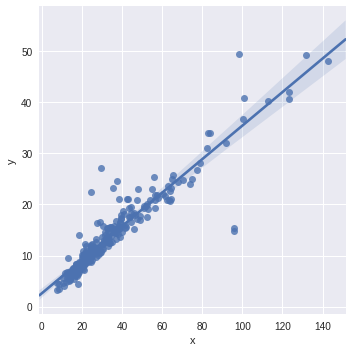

In [207]:
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)

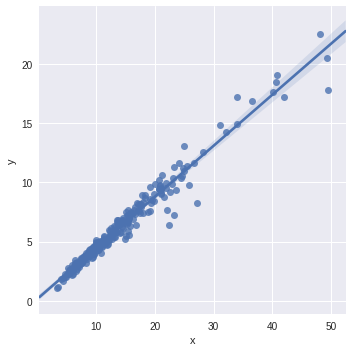

In [208]:
df5=pd.DataFrame({'x' : y, 'y': yerr})
sns.lmplot(x="x", y="y", data=df5)

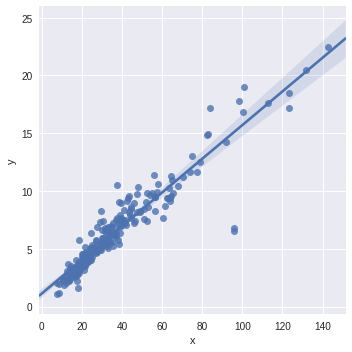

In [209]:
df5=pd.DataFrame({'x' : x, 'y': yerr})
sns.lmplot(x="x", y="y", data=df5)

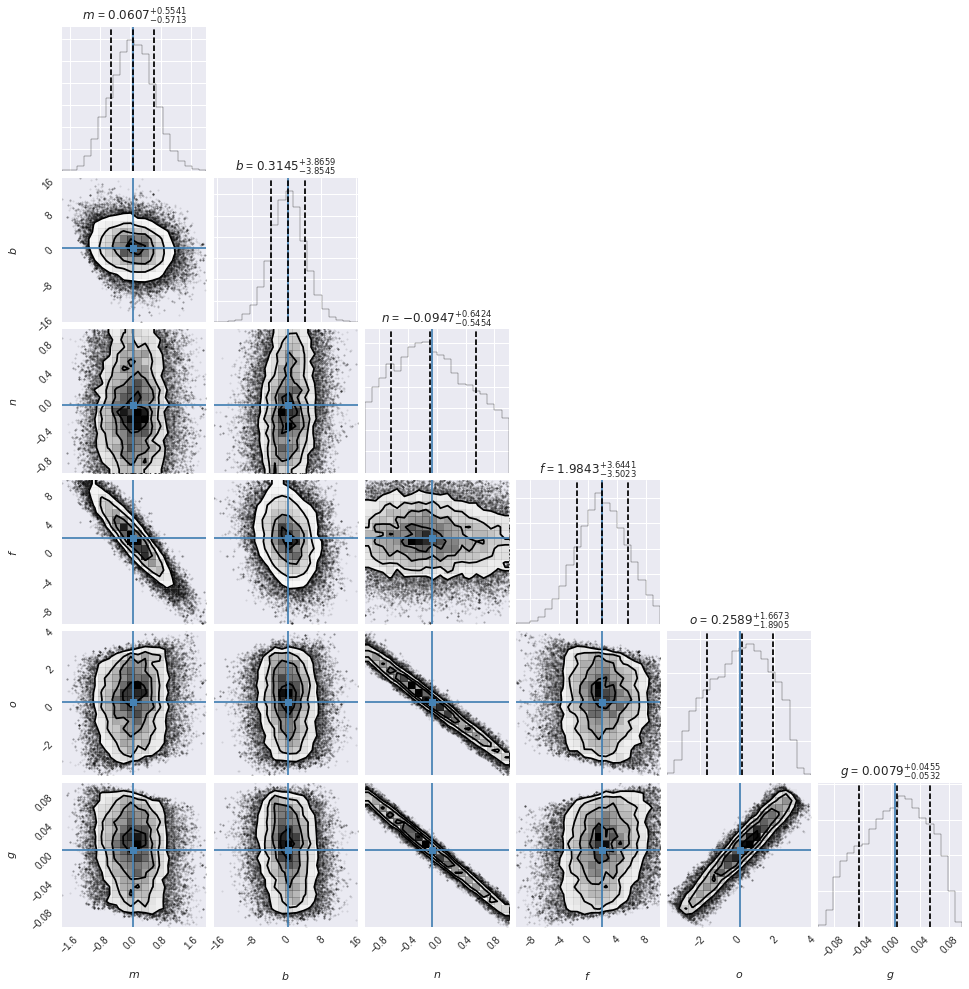

In [157]:
# This block uses the emcee MCMC sampler to estimate the posterior probability
# 1. Guess the starting places for the walkers from a maximum likelihood fit
nll = lambda *args: -lnlike(*args)
argum=(x, y,yerr,ydel)
result = op.minimize(nll, [1.]*6, args=argum)
m_ml, b_ml,n_ml,f_ml,o_ml,g_ml= result["x"]
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=argum) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$n$","$f$","$o$","$g$"],
                      truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

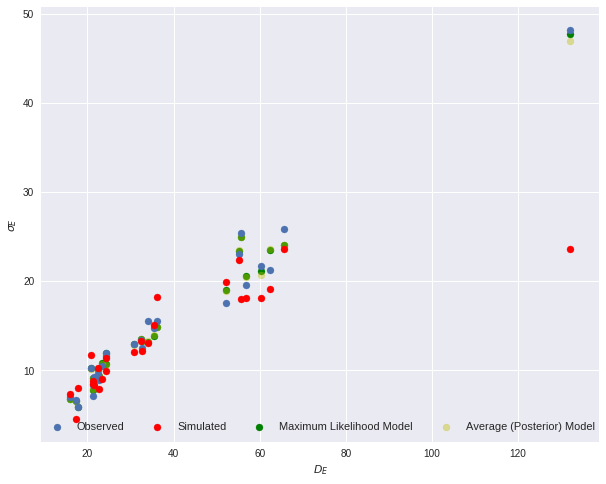

In [158]:
plt.figure(figsize=(10,8))

AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2
y_ml=m_ml*x+b_ml+n_ml*ydel*x+f_ml*ydel+o_ml*ydel**2+g_ml*x**2
y_me=meanest[0]*x+meanest[1]+meanest[2]*ydel*x+meanest[3]*ydel+meanest[4]*ydel**2+meanest[5]*x**2
plml = plt.scatter(x,y_ml,c='g')
plme = plt.scatter(x,y_me,c='y',alpha=0.4)
plobs = plt.scatter(x,y)
plsim = plt.scatter(x,y_sim,c='r')
#plt.scatter(x,w,c='k')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend((plobs, plsim, plml, plme),
           ('Observed', 'Simulated', 'Maximum Likelihood Model', 'Average (Posterior) Model'),
           scatterpoints=1,
           loc='lower center',
           ncol=4,
           fontsize=11)

plt.show()

Rejection rate (%): 1.4054799521366135
Bayesian p-value: 0.872066846492


(0, 95.527736268873795)

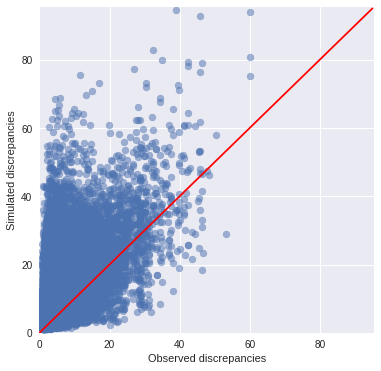

In [159]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,n,f,o,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2 # create a synthetic dataset
    yexp=m*x+b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

### Conclusiones
- Cuando nmeas > 14 el p es bueno, pero para nmeas > 13 ya es malo. Guardar p, nmeas, ngal
- Con el minimo nmeas (14) no se logra independencia de sigma_sigma (sigma_sigma_indep.ipynb)
- Funciona para nmeas > 20 con modelo lineal y yerr = f*x y tambien para sigma_b=pol(x,3) y yerr cuadrático -> el great model se va dañando --> señal de que modelos más simples funcionan
- No funciona cuando yerr es función de y (igual que en sigma_sigma_indep) - codigo en ysigma_sigma_indep.ipynb
- No funciona cuando el peso se toma como 1/yerr y yerr es función de y (sysigma_sigma_indep.ipynb)


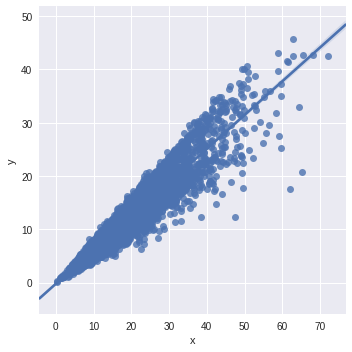

In [210]:
x=bootp50
y=bootsig
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)

In [211]:
def lnlikelin(theta, x, y,yerr):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b = theta
    if -2 < m < 2 and -20 < b < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)


In [162]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
yerr=ydel

In [163]:
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1., 1.], args=(x, y, yerr))
m_ml, b_ml = result["x"]
print(result["x"])

[ 0.37758559  0.60676898]


<Container object of 3 artists>

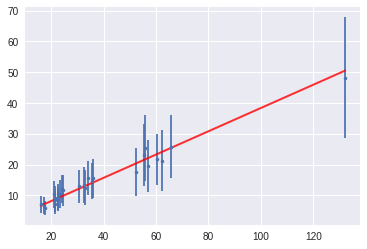

In [164]:
xl = np.array([x.min(), x.max()])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.errorbar(x,y,yerr=yerr,fmt='.')

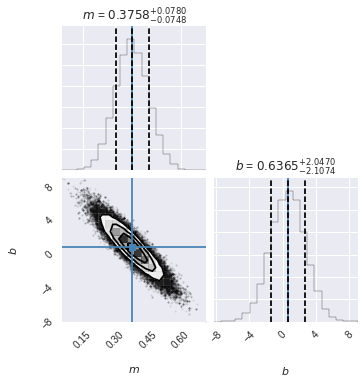

In [165]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

## Prueba lineal variando yerr

Independiente de bootsig (sigma_sigma). 

Para yerr=f*x no funciona. p es muy bajo. No es posible reproducir la varianza en los datos.

In [268]:
def lnlikelin(theta, x, y):
    m ,b,f = theta
    model = m * x +b
    yerr=f*x
    inv_sigma2 = 1.0/np.abs(yerr)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y)

In [269]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*3, args=(x, y))
m_ml, b_ml,f_ml = result["x"]
print(result["x"])

[ 0.34933932  1.84354302  0.20151172]


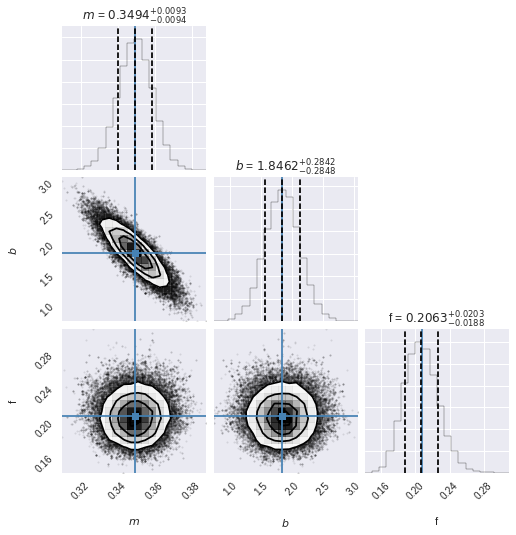

In [270]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","f"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 32.340746415581052)

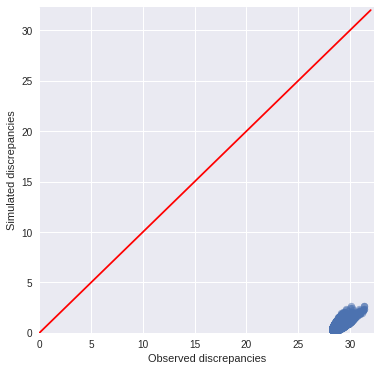

In [271]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1] # create a synthetic dataset
    yexp=m*x+b # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

Ahora para yerr=f*x+g tampoco funciona

In [272]:
def lnlikelin(theta, x, y):
    m ,b,f,g = theta
    model = m * x +b
    yerr=f*x+g
    inv_sigma2 = 1.0/np.abs(yerr)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f,g = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20 and -20 < g < 20:
        return 0.0
    return -np.inf
def lnproblin(theta, x, y):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y)

In [273]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*4, args=(x, y))
m_ml, b_ml,f_ml,g_ml = result["x"]
print(result["x"])

[ 0.35878395  1.50571714 -0.26279996  1.67838668]


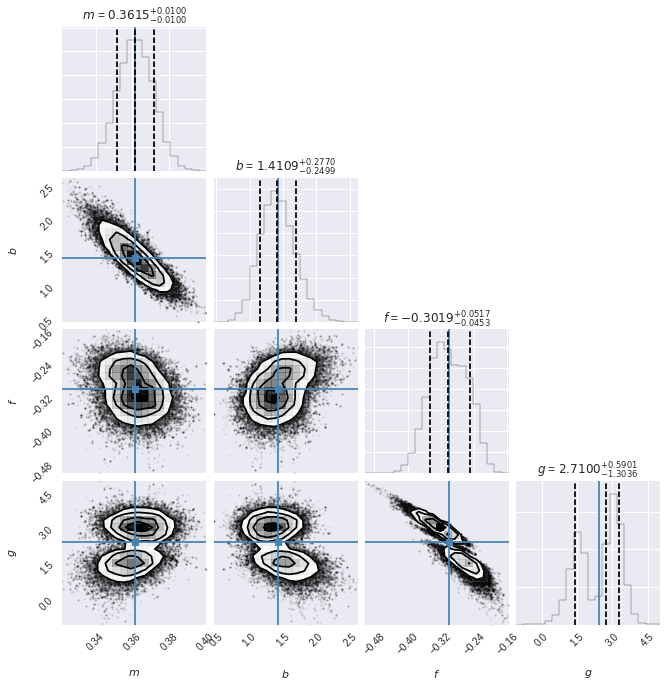

In [274]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$","$g$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 34.18671164061994)

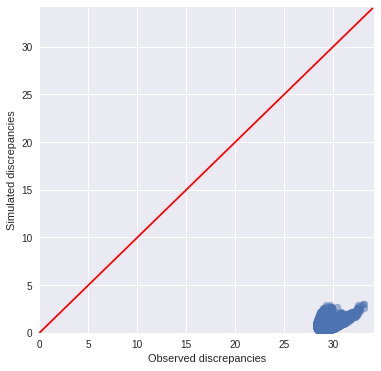

In [275]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1] # create a synthetic dataset
    yexp=m*x+b # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

Ahora para yerr^2=f^2+(g*x)^2 tampoco funciona

In [276]:
def lnlikelin(theta, x, y):
    m ,b,f,g = theta
    model = m * x +b
    yerr=f
    inv_sigma2 = 1.0/np.sqrt(yerr**2+(g*x)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f,g = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20 and -20 < g < 20:
        return 0.0
    return -np.inf
def lnproblin(theta, x, y):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y)

In [277]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*4, args=(x, y))
m_ml, b_ml,f_ml,g_ml = result["x"]
print(result["x"])

[  3.49339333e-01   1.84354269e+00   1.65949794e-06   2.01511722e-01]


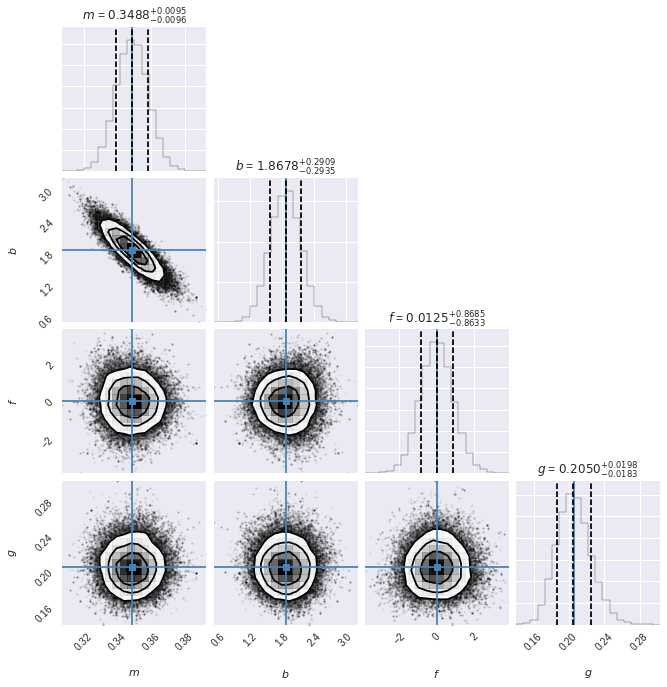

In [278]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$","$g$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 33.122495703678126)

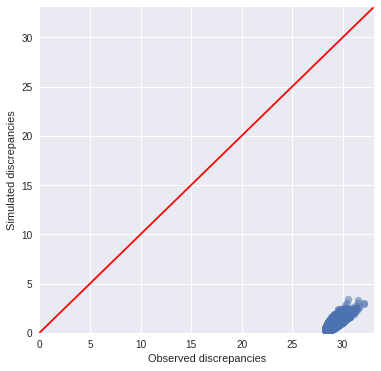

In [279]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1] # create a synthetic dataset
    yexp=m*x+b # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

## Prueba cuadratica variando yerr

Independiente de bootsig (sigma_sigma). 

Para yerr=f*x no funciona

In [280]:
def lnlikelin(theta, x, y):
    m ,b,f,n = theta
    model = m * x**2+b+n*x 
    yerr=f*x
    inv_sigma2 = 1.0/np.abs(yerr)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f,n = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20 and -20 < n < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y)

In [281]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*4, args=(x, y))
m_ml, b_ml,f_ml,n_ml = result["x"]
print(result["x"])

[-0.00086352  0.59970787  0.19156531  0.42794594]


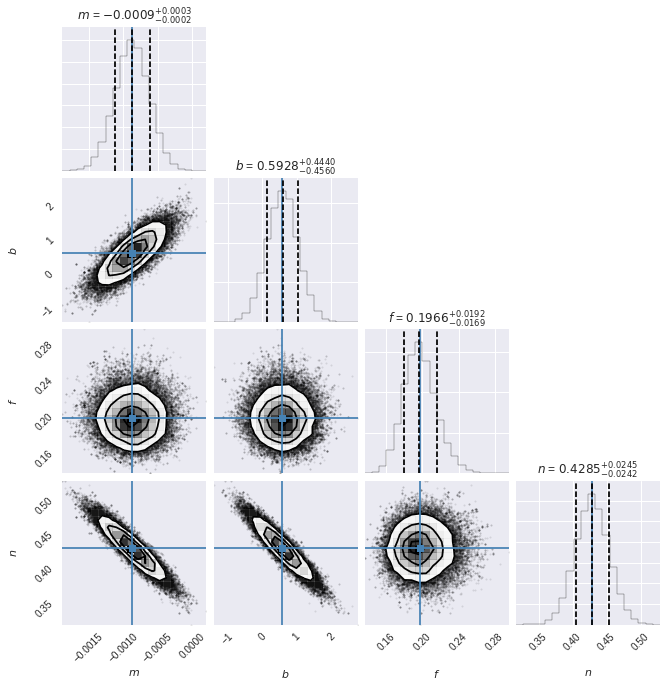

In [282]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$","$n$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 31.204338419962568)

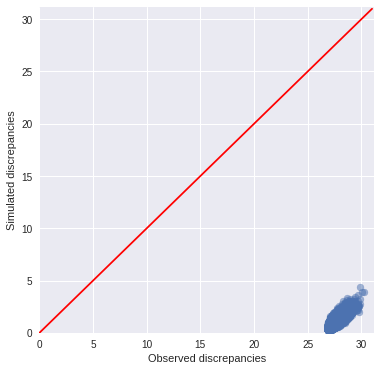

In [283]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f,n in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x**2+AAA[:,1]+AAA[:,3]*x # create a synthetic dataset
    yexp=m*x**2+b+n*x # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

Ahora para yerr=f*x+g tampoco funciona (desastroso, no hay mcmc)

Para yerr=(f*x)^2+g^2 tampoco funciona

In [284]:
def lnlikelin(theta, x, y):
    m ,b,f,n,g = theta
    model = m * x**2+b+n*x 
    yerr=g
    inv_sigma2 = 1.0/np.sqrt(yerr**2+(f*x)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f,n,g = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20 and -20 < n < 20 and -20 < g < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y)

In [285]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*5, args=(x, y))
m_ml, b_ml,f_ml,n_ml,g_ml = result["x"]
print(result["x"])

[ -8.63510933e-04   5.99715797e-01   1.91564972e-01   4.27945036e-01
   1.71767621e-06]


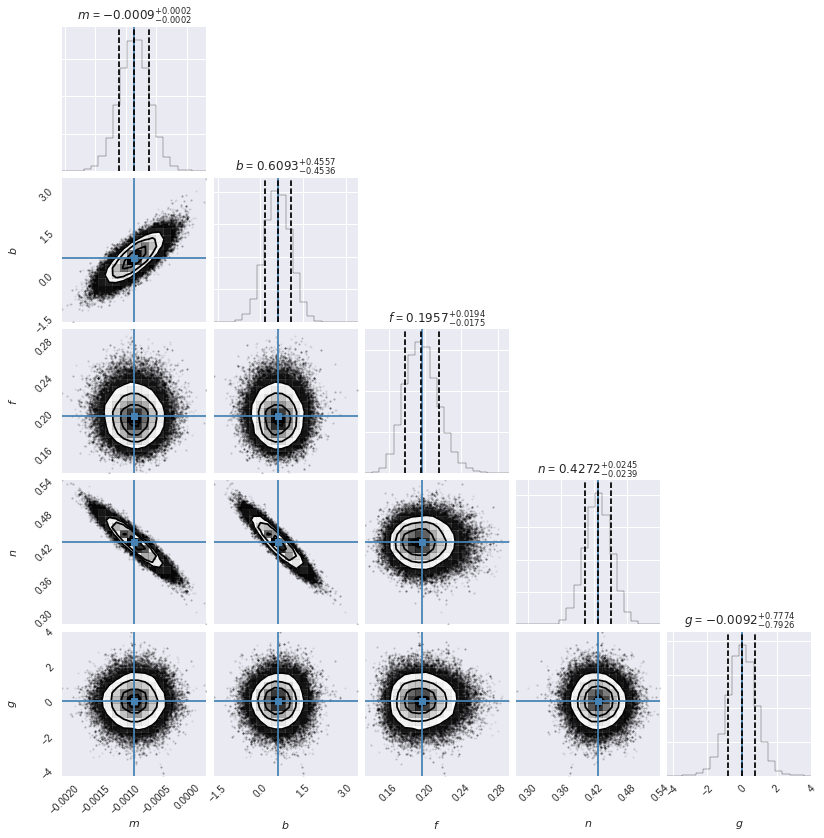

In [286]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 2000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$","$n$","$g$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 32.00662796255984)

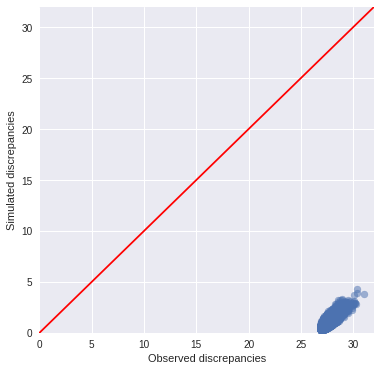

In [287]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f,n,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x**2+AAA[:,1]+AAA[:,3]*x # create a synthetic dataset
    yexp=m*x**2+b+n*x # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

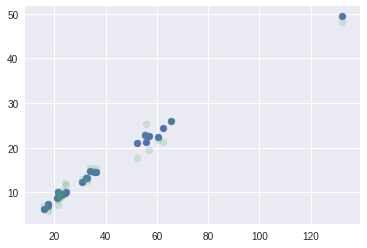

In [186]:
plt.scatter(x,y_sim)
plt.scatter(x,y,alpha=0.2)

In [187]:
y.shape

(26,)

In [188]:
y=np.array(bootp50)



In [189]:
k=0
myr=1000
for i in range(myr):
    p1=np.sort(np.random.normal(2.01,0.2,1000))
    p2=np.sort(np.random.normal(2,0.2,1000))
    p3=np.sort(np.random.normal(2,0.2,1000))
    ksan=ss.anderson_ksamp([p1,p2,p3])
    if ksan.statistic > ksan.significance_level:
        k+=1
k/myr

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


0.536

In [190]:
ss.anderson_ksamp([p1,p2,p3])

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=-0.1686782783093777, critical_values=array([ 0.44925884,  1.3052767 ,  1.9434184 ,  2.57696569,  3.41634856]), significance_level=0.4839994150713497)

(array([   3.,    4.,   26.,   81.,  185.,  256.,  244.,  130.,   56.,   15.]),
 array([ 1.23908141,  1.37235938,  1.50563735,  1.63891533,  1.7721933 ,
         1.90547127,  2.03874925,  2.17202722,  2.3053052 ,  2.43858317,
         2.57186114]),
 <a list of 10 Patch objects>)

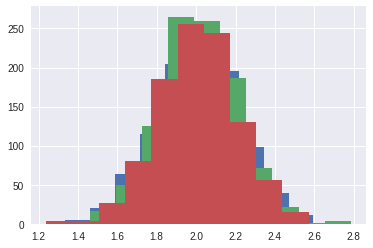

In [191]:
plt.hist(p1)
plt.hist(p2)
plt.hist(p3)

In [192]:
ss.anderson_ksamp([y,y_sim,yexp])

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=7.7176953726283273, critical_values=array([ 0.44925884,  1.3052767 ,  1.9434184 ,  2.57696569,  3.41634856]), significance_level=7.971553219922106e-05)

If A2 is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected.

In [288]:
def lnlikelin(theta, x, y):
    m ,b,f,n,g,h = theta
    model = m * x**2+b+n*x +h*x**3
    yerr=g
    inv_sigma2 = 1.0/np.sqrt(yerr**2+(f*x)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f,n,g,h = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20 and -20 < n < 20 and -20 < g < 20  and -20 < h < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y)

In [289]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*6, args=(x, y))
m_ml, b_ml,f_ml,n_ml,g_ml,h_ml = result["x"]
print(result["x"])

[ -3.86930251e-03  -8.35179001e-01   1.25502987e+00   5.58907118e-01
   5.77339194e-02   1.73285969e-05]


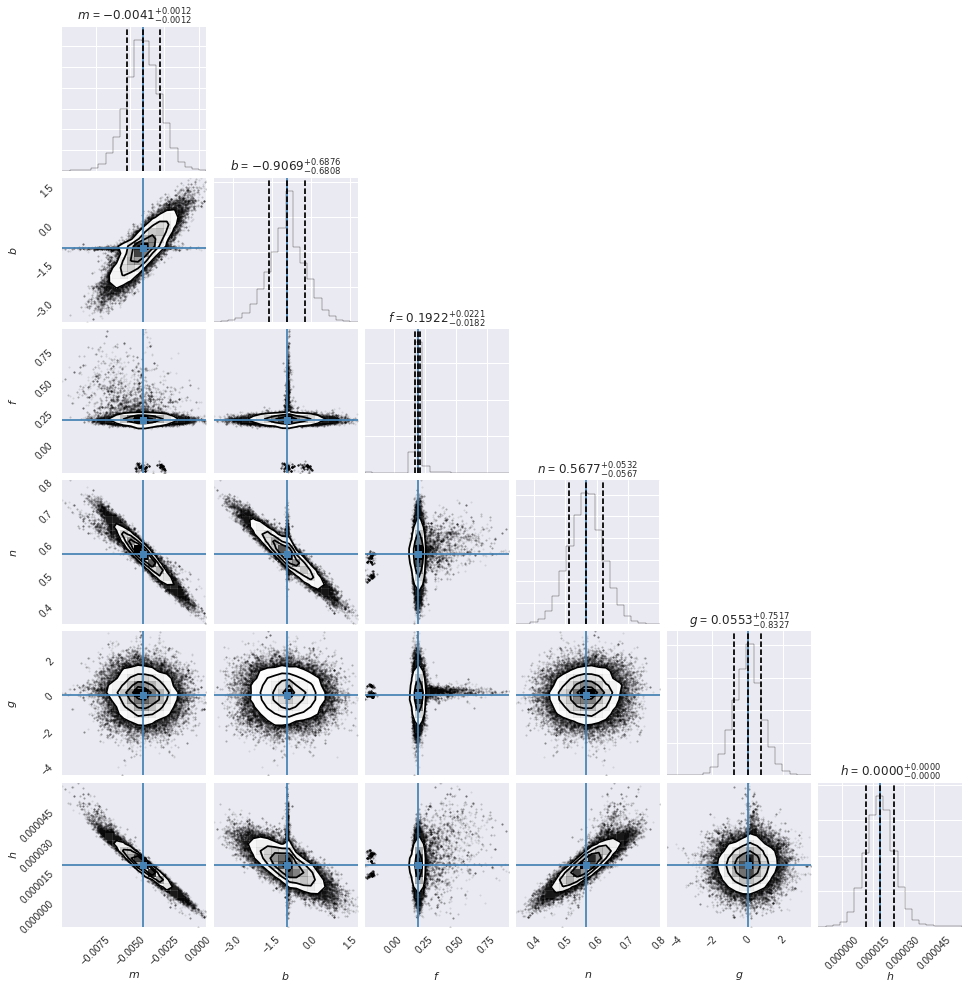

In [290]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$","$n$","$g$","$h$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 46.31849253393888)

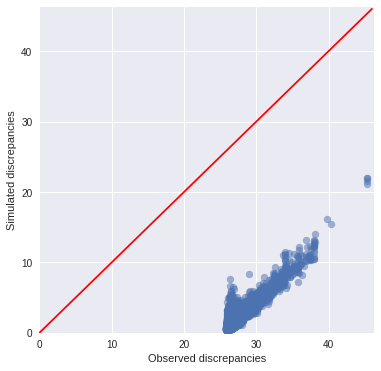

In [291]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f,n,g,h in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x**2+AAA[:,1]+AAA[:,3]*x+AAA[:,5]*x**3 # create a synthetic dataset
    yexp=m*x**2+b+n*x+h*x**3 # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)